In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from edca_analysis.sdca_gaussian_exogenous import SupervisedDCA as SDCAe
import pickle
from scipy.stats import boxcox

from edca_analysis.plot_utils import axplot_imshow, append_marginal_axis

In [3]:
DATA_DIR = "../OFC_data/"
IMG_DIR = "./images/EC125"
os.makedirs(IMG_DIR, exist_ok=True)
fn = "v7_EC142_TimeAveragedSpectraPower_6mA_FreqBands.pkl"
patient = fn.split("_")[1]
current = [i for i in fn.split("_") if "mA" in i][0]
savefig = False
patient, current

('EC142', '6mA')

In [4]:
with open(f"{DATA_DIR}/{fn}", "rb") as f:
    data_dict = np.load(f, allow_pickle=True).item()

In [5]:
power = data_dict["power_stim"]
freqs = data_dict["freqs"]
finalVerifiedChanNames = data_dict["finalVerifiedChanNames"]
finalVerifiedRegions = data_dict["finalVerifiedRegions"]
regionNames = data_dict["regionNames"]

print(power.shape)
cutoff_freq = 28
cutoff_idx = np.where(freqs > cutoff_freq)[0][0]
power = power[:, :cutoff_idx]
print(cutoff_idx)
freqs = freqs[:cutoff_idx]
print(power.shape)

(12, 31, 64712)
20
(12, 20, 64712)


In [ ]:
finalVerifiedChanNames, finalVerifiedRegions, regionNames

(array(['OFA1', 'OFA2', 'OFB1', 'OFB2', 'HD1', 'HD2', 'HD3', 'INS1',
        'INS2', 'INS3', 'DC2', 'DC3'], dtype='<U4'),
 array([1, 1, 1, 1, 3, 3, 3, 4, 4, 4, 6, 6], dtype=uint8),
 array(['OFC', 'Amygdala', 'Hippocampus', 'Insula', 'Ventral Cingulate',
        'Dorsal Cingulate'], dtype='<U17'))

In [ ]:
Fs = data_dict["Fs"]
dsFs = data_dict["dsFs"]
# stim_start = int(np.floor(int(1.0 * data_dict["stimStartSample"]) * dsFs / Fs))
# stim_end = int(np.floor(int(1.0 * data_dict["stimEndSample"]) * dsFs / Fs))

stim_start = int(1.0 * data_dict["stimStartSample"])
stim_end = int(1.0 * data_dict["stimEndSample"])

print(stim_start, stim_end)
print(stim_start / dsFs, stim_end / dsFs)

6254 58356
12.21484375 113.9765625


In [25]:
region = "OFC"
region_idx = np.where(np.array(regionNames) == region)[0][0] + 1
chan_idx = np.where(np.array(finalVerifiedRegions) == region_idx)[0]
chan_idx, region_idx

(array([7, 8, 9]), 4)

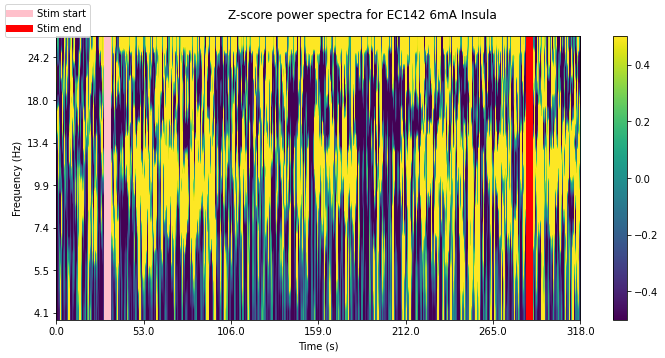

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))
# this is spectrogram of one electrode (or averaged), dimensions (freq, time)
plt_data = np.mean(power[chan_idx], axis=0)  # average over electrodes in OFC
# plt_data = power[0]  # one electrode in OFC

# take z-score of power spectra before stim
plt_data = (
    plt_data - np.mean(plt_data[:, :stim_start], axis=1, keepdims=True)
) / np.std(plt_data[:, :stim_start], axis=1, keepdims=True)

im = ax.imshow(
    plt_data, aspect="auto", cmap="viridis", vmin=-0.5, vmax=0.5
)  # plot lower frequency at bottom
ax.axvline(stim_start, color="pink", lw=7, label="Stim start")
ax.axvline(stim_end, color="red", lw=7, label="Stim end")
fig.colorbar(im, ax=ax)
ax.invert_yaxis()
y_steps = 6
chosen_indices = np.arange(0, len(power[0]))[:: len(power[0]) // (y_steps)]
ax.set_yticks(chosen_indices)
ax.set_yticklabels(np.round([freqs[i] for i in chosen_indices], 1))
time_steps = 6
time_indices = np.arange(0, len(plt_data[0]))[:: len(plt_data[0]) // (time_steps)]
ax.set_xticks(time_indices)
ax.set_xticklabels(np.round([i / Fs * 15 for i in time_indices]))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
# ax.set_title(f"{finalVerifiedChanNames[0]}")

title = f"Z-score power spectra for {patient} {current} {region}"
fig.suptitle(f"{title}")
fig.legend(loc="upper left")
fig.tight_layout()
savefig = False
if savefig:
    fig.savefig(f"{IMG_DIR}/{title}.png", facecolor="white", transparent=False, dpi=300)

In [45]:
curr_pow = np.mean(power[chan_idx], axis=0)
transformed = [boxcox(curr_power[:stim_start]) for curr_power in curr_pow]
boxcox_lambda = [second for (first, second) in transformed]
np.round(boxcox_lambda, 3)

array([-0.283, -0.197, -0.019, -0.023, -0.121, -0.005,  0.11 ,  0.108,
        0.157,  0.132,  0.014,  0.026,  0.167,  0.27 ,  0.279,  0.143,
        0.285,  0.23 ,  0.212,  0.196])

In [46]:
data = np.array(
    [
        boxcox(curr_power, lmbda=boxcox_lambda[i])
        for i, curr_power in enumerate(curr_pow)
    ]
)

In [47]:
data = (data - np.mean(data[:, :stim_start], axis=1, keepdims=True)) / np.std(
    data[:, :stim_start], axis=1, keepdims=True
)
data = data.T
print(data.shape)

(64712, 20)


## Region 2

In [32]:
region2 = "Insula"
region2_idx = np.where(np.array(regionNames) == region2)[0][0] + 1
chan2_idx = np.where(np.array(finalVerifiedRegions) == region2_idx)[0]
chan_idx, region2_idx

(array([7, 8, 9]), 4)

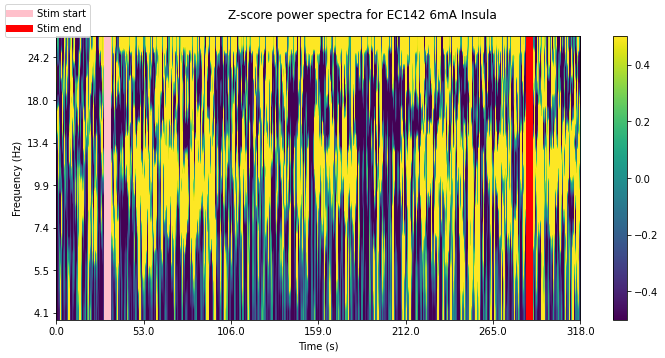

In [33]:
fig, ax = plt.subplots(figsize=(10, 5))
# this is spectrogram of one electrode (or averaged), dimensions (freq, time)
plt_data = np.mean(power[chan2_idx], axis=0)  # average over electrodes in OFC
# plt_data = power[0]  # one electrode in OFC

# take z-score of power spectra before stim
plt_data = (
    plt_data - np.mean(plt_data[:, :stim_start], axis=1, keepdims=True)
) / np.std(plt_data[:, :stim_start], axis=1, keepdims=True)

im = ax.imshow(
    plt_data, aspect="auto", cmap="viridis", vmin=-0.5, vmax=0.5
)  # plot lower frequency at bottom
ax.axvline(stim_start, color="pink", lw=7, label="Stim start")
ax.axvline(stim_end, color="red", lw=7, label="Stim end")
fig.colorbar(im, ax=ax)
ax.invert_yaxis()
y_steps = 6
chosen_indices = np.arange(0, len(power[0]))[:: len(power[0]) // (y_steps)]
ax.set_yticks(chosen_indices)
ax.set_yticklabels(np.round([freqs[i] for i in chosen_indices], 1))
time_steps = 6
time_indices = np.arange(0, len(plt_data[0]))[:: len(plt_data[0]) // (time_steps)]
ax.set_xticks(time_indices)
ax.set_xticklabels(np.round([i / Fs * 15 for i in time_indices]))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
# ax.set_title(f"{finalVerifiedChanNames[0]}")

title = f"Z-score power spectra for {patient} {current} {region}"
fig.suptitle(f"{title}")
fig.legend(loc="upper left")
fig.tight_layout()
savefig = False
if savefig:
    fig.savefig(f"{IMG_DIR}/{title}.png", facecolor="white", transparent=False, dpi=300)

In [42]:
curr_pow = np.mean(power[chan2_idx], axis=0)
transformed = [boxcox(curr_power[:stim_start]) for curr_power in curr_pow]
boxcox_lambda = [second for (first, second) in transformed]
np.round(boxcox_lambda, 3)

array([-0.283, -0.197, -0.019, -0.023, -0.121, -0.005,  0.11 ,  0.108,
        0.157,  0.132,  0.014,  0.026,  0.167,  0.27 ,  0.279,  0.143,
        0.285,  0.23 ,  0.212,  0.196])

In [43]:
data2 = np.array(
    [
        boxcox(curr_power, lmbda=boxcox_lambda[i])
        for i, curr_power in enumerate(curr_pow)
    ]
)

In [44]:
data2 = (data2 - np.mean(data2[:, :stim_start], axis=1, keepdims=True)) / np.std(
    data2[:, :stim_start], axis=1, keepdims=True
)
data2 = data2.T
print(data2.shape)

(64712, 20)


## Fit eDCA

In [48]:
def get_xdca_projections(X, U, T, d, d_exo, rng_or_seed=0):

    sdcae_model = SDCAe(d=d, d_exo=d_exo, T=T, rng_or_seed=rng_or_seed)
    sdcae_model.fit(X, U)
    V_sdcae = sdcae_model.coef_
    V_sdcae_exo = sdcae_model.coef_exogenous_

    return sdcae_model, V_sdcae, V_sdcae_exo

In [50]:
d = 5
d_exo = 3
T = 5

sdcae_model, V, V_exo = get_xdca_projections(data, data2, T=T, d=d, d_exo=d_exo)

In [51]:
def axplot_imshow_data(
    ax,
    data,
    xmin,
    xmax,
    ymin,
    ymax,
    vmin=None,
    vmax=None,
    vmax_quantile=None,
    cmap="gray_r",
    show_ratio=0.12,
    interpolation="antialiased",
    ylabel=None,
    title=None,
):

    if vmax is None:
        if vmax_quantile is None:
            vmax = np.max(np.abs(data))
        else:
            vmax = np.quantile(np.abs(data), vmax_quantile)
    if vmin is None:
        vmin = -vmax

    im = ax.imshow(
        data.T,
        cmap=cmap,
        extent=(xmin, xmax, ymax, ymin),
        aspect=(show_ratio * (xmax - xmin) / (ymax - ymin)),
        vmin=vmin,
        vmax=vmax,
        interpolation=interpolation,
    )
    if title is not None:
        ax.set_title(title)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    ax.set_ylim((ymin, ymax))

    return im

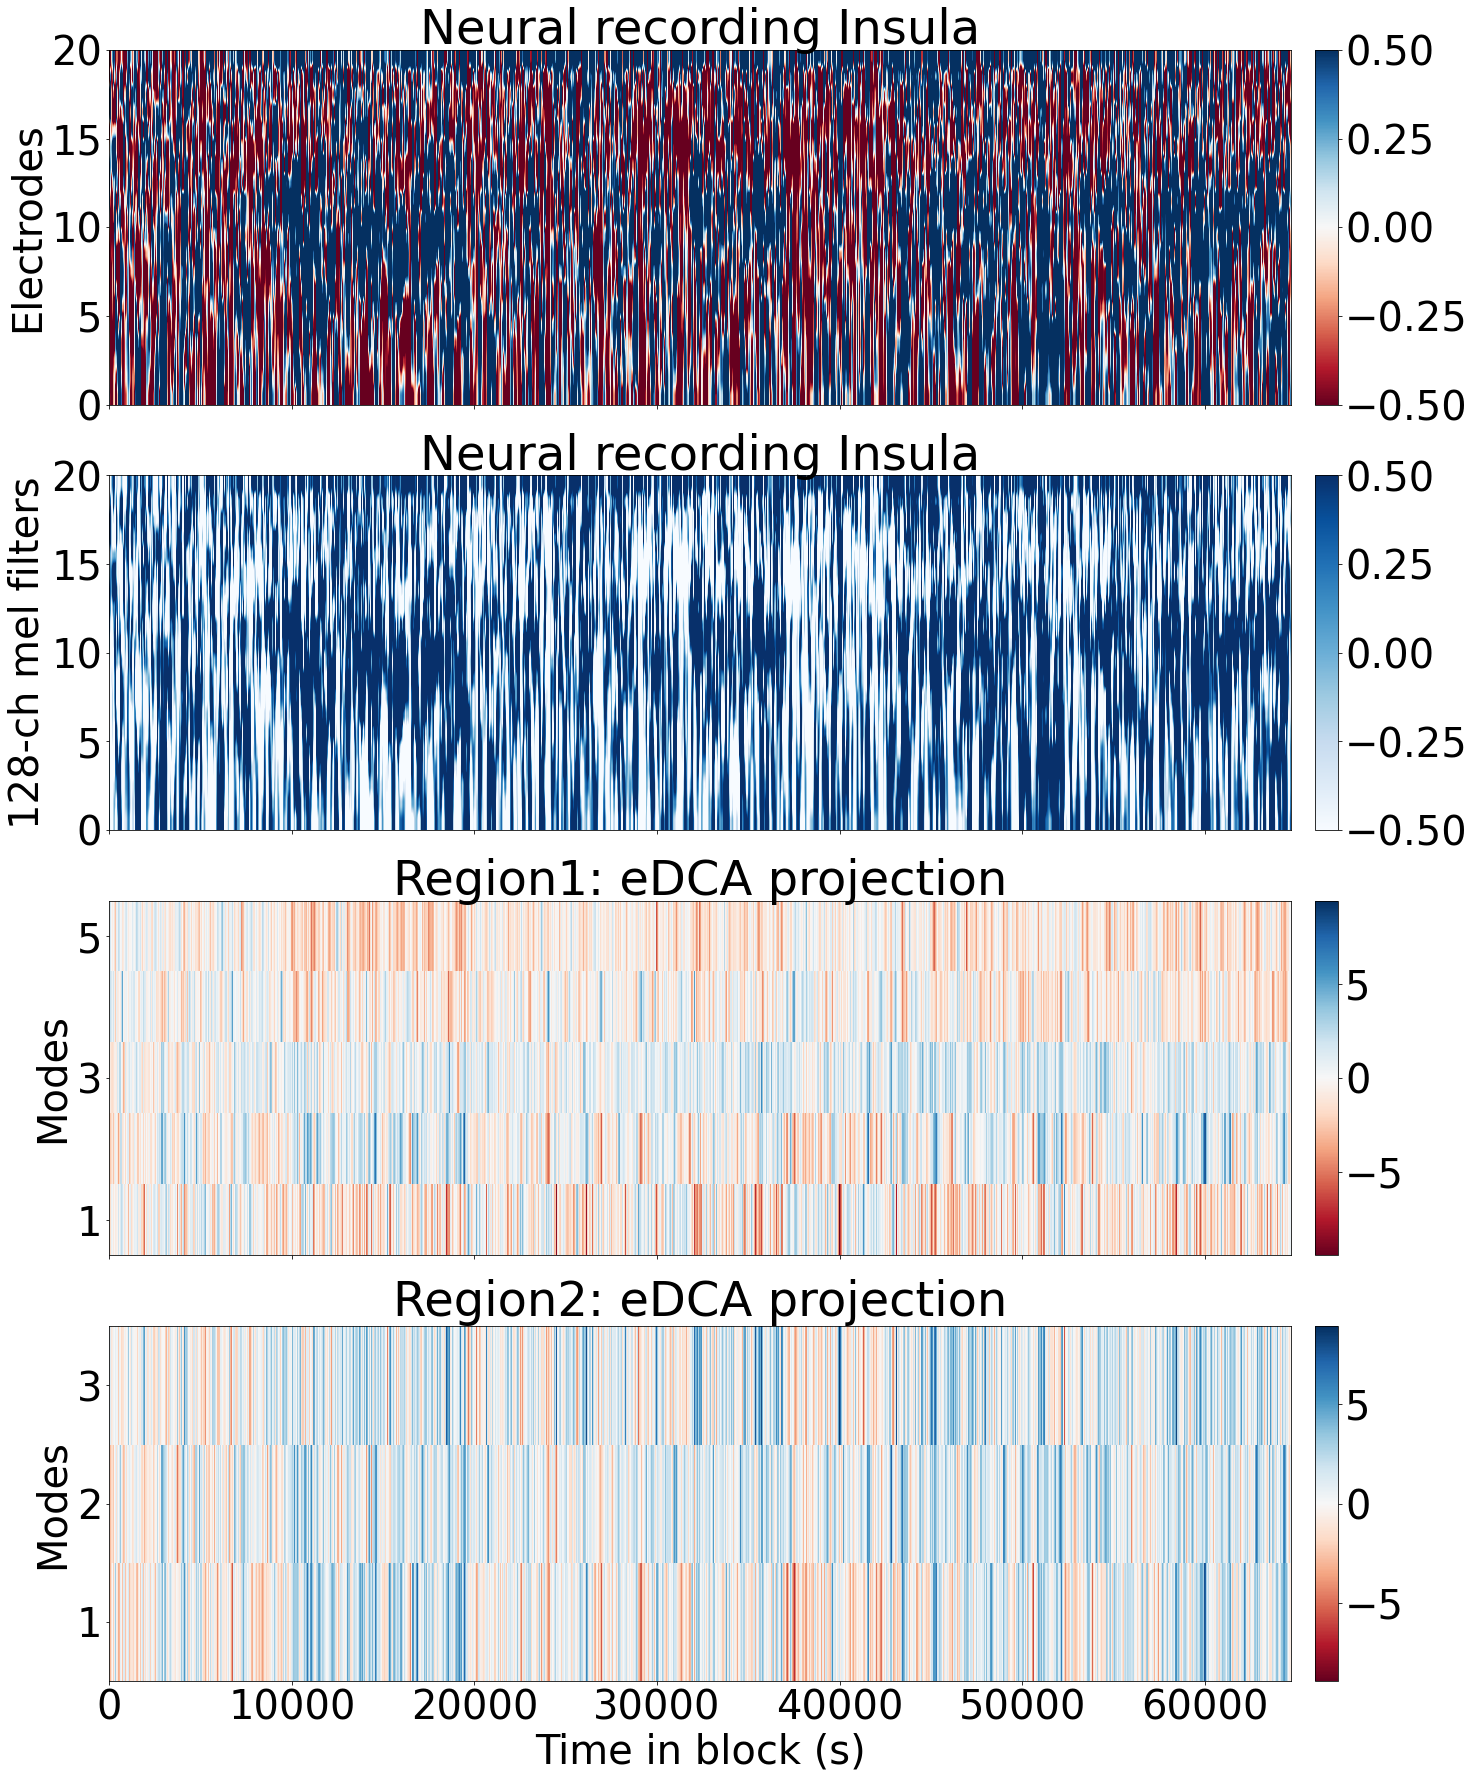

In [55]:
show_ratio = 0.3
plt.rc("font", size=40)

cb_kwargs = dict(spacing=0.02, width=0.02, which="x")

fig, axes = plt.subplots(4, 1, figsize=(30, 30), sharex=True)
# fig.subplots_adjust(top=0.3)

# --- input data ---

ax = axes[0]
im = axplot_imshow_data(
    ax,
    data,
    xmin=0,
    xmax=len(data),
    ymin=0,
    ymax=len(data[1]),
    vmin=-0.5,
    vmax=0.5,
    show_ratio=show_ratio,
    cmap="Blues",
    ylabel="Electrodes",
    title=f"Neural recording {region}",
)
# colorbar
cbar_ax = append_marginal_axis(ax, **cb_kwargs)
fig.colorbar(im, cax=cbar_ax)

ax = axes[1]
im = axplot_imshow_data(
    ax,
    data2,
    xmin=0,
    xmax=len(data2),
    ymin=0,
    ymax=len(data2[1]),
    show_ratio=show_ratio,
    vmin=-0.5,
    vmax=0.5,
    cmap="Blues",
    ylabel="128-ch mel filters",
    # title='speech mel spectrogram',
    title=f"Neural recording {region2}",
)
# colorbar
cbar_ax = append_marginal_axis(ax, **cb_kwargs)
fig.colorbar(im, cax=cbar_ax)


# --- xDCA projections ---

V_list = [V]
titles = [f"{region}: eDCA projection"]

for ax, title, V_tmp in zip(axes[2:3], titles, V_list):
    X_proj = data @ V_tmp
    im = axplot_imshow_data(
        ax,
        X_proj,
        xmin=0,
        xmax=len(data),
        ymin=0,
        ymax=d,
        show_ratio=show_ratio,
        interpolation="none",
        cmap="Blues",
        ylabel="Modes",
        title=title,
    )
    ax.set_yticks([0.5, 2.5, 4.5])
    ax.set_yticklabels([1, 3, 5])
    # colorbar
    cbar_ax = append_marginal_axis(ax, **cb_kwargs)
    fig.colorbar(im, cax=cbar_ax)


ax = axes[3]
U_proj = data2 @ V_exo
im = axplot_imshow_data(
    ax,
    U_proj,
    xmin=0,
    xmax=len(data),
    ymin=0,
    ymax=d_exo,
    show_ratio=show_ratio,
    interpolation="none",
    cmap="Blues",
    ylabel="Modes",
    title=f"{region2}: eDCA projection",
)
ax.set_yticks([0.5, 1.5, 2.5])
ax.set_yticklabels([1, 2, 3])
# colorbar
cbar_ax = append_marginal_axis(ax, **cb_kwargs)
fig.colorbar(im, cax=cbar_ax)


# --- final annotations ---

ax.set_xlabel("Time in block (s)")

annotate_color = "k"
# for ax in axes.ravel():
#     y = ax.get_ylim()[1] * 0.95
#     for t, word in zip(word_onset_times, word_list):
#         ax.axvline(t, color=annotate_color, linestyle="--", zorder=1)
#         ax.annotate(f" {word}", (t, y), color=annotate_color, va="top", ha="left")
#     ax.set_xlim((times[0] - 0.01, times[-1]))

# fig.suptitle(f'\'\'{sentence}\'\'', y=0.96)

fig.show()
fig.savefig(f"{IMG_DIR}/chang.png", dpi=300)

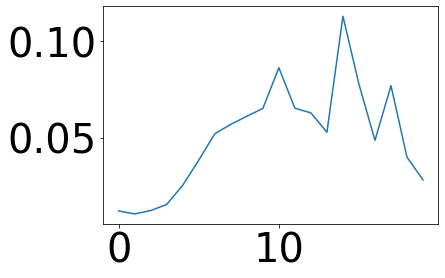

In [59]:
fig, ax = plt.subplots(1, 1)

ax.plot(np.mean(V_exo**2, axis=1))

In [58]:
V.shape

(20, 5)

In [1]:
16232133677 / (10**9)

16.232133677